In [120]:
import torch.nn as nn
import torch

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.input = nn.Linear(784,512)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(512,128)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,10)
        
        # decoder
        self.up_fc1 = nn.Linear(10,32)
        self.up_fc2 = nn.Linear(32,128)
        self.up_fc3 = nn.Linear(128,512)
        self.up_fc4 = nn.Linear(512,784)
        self.sigmoid = nn.Sigmoid()

        
    def encoder(self, x):
        x = self.input(x)
        x = self.relu(x)
        x = self.tanh(x) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.tanh(x) 
        x = self.fc2(x)
        x = self.tanh(x) 
        x = self.fc3(x)
        return x
        
    def decoder(self, x):
        x = self.up_fc1(x)
        x = self.tanh(x)
        x = self.up_fc2(x)
        x = self.tanh(x)
        x = self.up_fc3(x)
        x = self.tanh(x)
        x = self.up_fc4(x)
        x = self.sigmoid(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [157]:
import torch
import numpy as np

x = train_dataset.data.flatten(1)
min_val = x.min()
max_val = x.max()
x = (x - min_val) / (max_val - min_val)
y = train_dataset.targets

inner_vector = torch.zeros(28*28, dtype=torch.float)
intra_vector = torch.zeros(28*28, dtype=torch.float)

    

def inter_calculate(i,x,y):
    data_with_label = {}
    
    for label in range(10):
        temp = []
        for j, target  in enumerate(y):
            if target.item() == label:
                temp.append(x[j,i].item())
        data_with_label[label]  = temp
    
    b  = {}
    for label in range(10):
        result = 0.0
        count = 0
        for j in range(len(data_with_label[label])):
            for z in range(j + 1, len(data_with_label[label])):
                diff_squared = (data_with_label[label][j] -data_with_label[label][z]) ** 2
                result += np.exp(-diff_squared)
                count += 1

        b[label] = result / count
    return sum(b.values()) / len(b)

import numpy as np

def apply_function_to_pq(p, q):
    min_length = min(len(p), len(q))
    p = np.array(p[:min_length])
    q = np.array(q[:min_length])
    
    result = 1 - np.exp(-(p - q) ** 2)
    return result


def intra_calculate(i, x, y):
    data_with_label = {}
    for p in range(10):
        for q in range(9, -1, -1):
            if p != q:
                temp_p = []
                temp_q = []
                for j, target in enumerate(y):
                    if target.item() == p:
                        temp_p.append(x[j, i].item())
                    if target.item() == q:
                        temp_q.append(x[j, i].item())
                
                data_with_label[f"{p}-{q}"] = [temp_p, temp_q]
                
                
        label_results = {label: [] for label in range(10)}        
        for label in range(10):
            keys = [key for key in data_with_label.keys() if key.startswith(f'{label}-')]
            for key in keys:
                p, q = data_with_label[key]
                result = apply_function_to_pq(p, q)
                label_results[label].extend(result) 
        label_means = {label: np.mean(results) for label, results in label_results.items()}

                

    return sum(label_means.values()) / len(label_means)

result = intra_calculate(196, x[:1000, :], y[:1000])

    
for i in range(28*28):
    inner_vector[i] = inter_calculate(i,x[:1000,:],y[:1000])
    intra_vector[i] = intra_calculate(i,x[:1000,:],y[:1000])

w = intra_vector - inner_vector

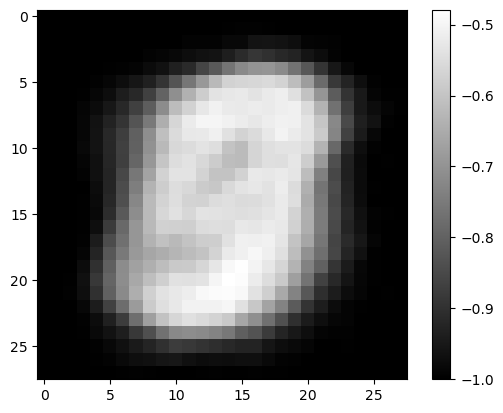

In [158]:
import matplotlib.pyplot as plt

# Assuming w is a PyTorch tensor
mask = w.cpu().detach().numpy()  # Convert the tensor to a NumPy array
mask =mask.reshape(28, 28)  # Reshape it to a 28x28 array

# Create a plot to visualize w as a 28x28 image
plt.imshow(mask, cmap='gray')  # You can choose a different colormap if desired
plt.colorbar()  # Add a color bar to the plot to show the values
plt.show()

In [148]:
import torch.optim as optim

autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.003)


In [149]:
def custom_loss(outputs, inputs,w, model_parameters):
    outputs = outputs.to(device)
    inputs = inputs.to(device)
    w = w.to(device)
    
    cmse_loss =  (w * ((outputs - inputs) ** 2)).mean()
    l2_penalty = 0.00001  * sum([(p**2).sum() for p in model_parameters])
    loss = 100 * cmse_loss + l2_penalty
    return loss

In [150]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

In [151]:
from torch.optim.lr_scheduler import StepLR


num_epochs = 10
autoencoder.to(device)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:
        inputs, truth = data
        inputs = inputs.to(device).view(-1, 784)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
#         pred  = autoencoder.encoder(inputs)
        loss = custom_loss(outputs, inputs,w, autoencoder.parameters())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    lr_scheduler.step() 
    with torch.no_grad():
        test_running_loss=0
        for data in test_loader:
            inputs, truth = data
            inputs = inputs.to(device).view(-1, 784)
            outputs = autoencoder(inputs)
            loss = custom_loss(outputs, inputs,w, autoencoder.parameters())
            test_running_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss:{running_loss}, Test Loss:{test_running_loss}")
            
        

Epoch 1, Train Loss:5903.637045264244, Test Loss:886.5332119464874
Epoch 2, Train Loss:4221.421293139458, Test Loss:781.761311173439
Epoch 3, Train Loss:3714.625694513321, Test Loss:679.9005337953568
Epoch 4, Train Loss:3432.067262530327, Test Loss:678.5738754272461
Epoch 5, Train Loss:3272.882066845894, Test Loss:644.9917426109314
Epoch 6, Train Loss:3163.455372095108, Test Loss:633.5508385896683
Epoch 7, Train Loss:3102.3522943258286, Test Loss:590.8408235311508
Epoch 8, Train Loss:3046.598017334938, Test Loss:598.668300151825
Epoch 9, Train Loss:2986.5347430706024, Test Loss:562.9964051246643
Epoch 10, Train Loss:2934.907313346863, Test Loss:566.6484013795853


In [165]:

for data in train_loader:
    x_sample, y_sample = data
    break

output = autoencoder(x_sample.to(device).view(-1, 784))

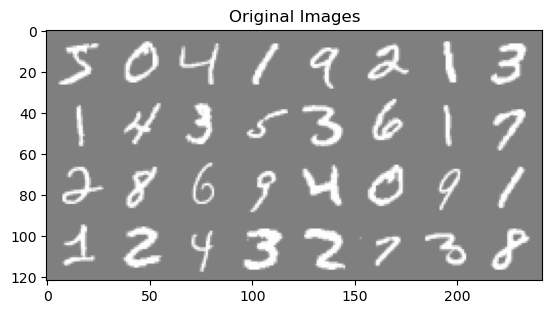

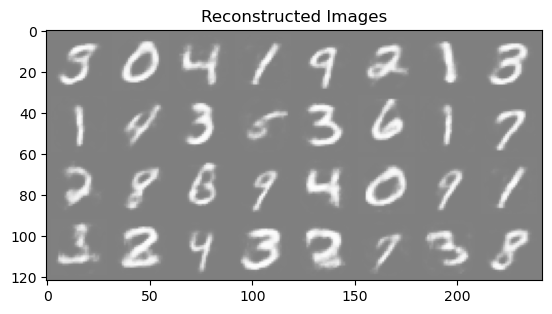

In [168]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Display the original input
imshow(torchvision.utils.make_grid(x_sample), title="Original Images")
output = output.view(-1, 1, 28, 28)
# Display the reconstructed output
imshow(torchvision.utils.make_grid(output.cpu()), title="Reconstructed Images")
